In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [79]:
from nba_api.stats.static import teams 
from nba_api.stats.endpoints import leaguegamefinder 
import pandas as pd
import csv

teams = teams.get_teams()
#print(teams)

all_games = leaguegamefinder.LeagueGameFinder().get_data_frames()[0]

# List of current NBA team IDs
current_teams = [1610612737, 1610612738, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
#print(current_teams)

# Filter the data to include only current NBA teams
data = all_games[all_games['TEAM_ID'].isin(current_teams)]
#print('base_data = ',data.columns)

#adding PER
data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV'])


#***PRE PROCESSING***
#*Date transformations
# Convert the date column to datetime format
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Extract numerical features from the date column
data['YEAR'] = data['GAME_DATE'].dt.year
data['MONTH'] = data['GAME_DATE'].dt.month
data['DAY'] = data['GAME_DATE'].dt.day


#**Convert all non-numeric values in a column
# Encode non-numeric values in the 'TEAM_ID' column as categorical variables
data_encoded = pd.get_dummies(data, columns=['TEAM_ID'], prefix='TEAM')

#**Drop Missing values
# Drop rows with missing values
data_encoded = data_encoded.dropna()

# Filter the data to include only selected columns
data_encoded_selected = data_encoded.iloc[:, :31]

# Get Unique Teams prior to modeling <takes out all the other games for these teams, find why Mavs are showing up twice in final set>
#data_encoded_unique = data_encoded_selected.drop_duplicates(subset='TEAM_NAME').copy()

# Check the updated column names in the DataFrame
print('encoded_data = ',data_encoded_selected.columns)
#print(data_encoded_selected)

# Filter the data for the 2022-2023 NBA season
#could also use season_id = 42022
start_date = pd.to_datetime('2022-10-01')
end_date = pd.to_datetime('2023-06-30')
season_data = data_encoded_selected[(data_encoded_selected['GAME_DATE'] >= start_date) & (data_encoded_selected['GAME_DATE'] <= end_date)].copy()

# Encode 'WL' column as 1 for 'W' (win) and 0 for 'L' (loss)
season_data['WL_encoded'] = season_data['WL'].apply(lambda x: 1 if x == 'W' else 0)
print(season_data.head())



encoded_data =  Index(['SEASON_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE',
       'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'PER', 'YEAR', 'MONTH', 'DAY'],
      dtype='object')
    SEASON_ID TEAM_ABBREVIATION       TEAM_NAME     GAME_ID  GAME_DATE  \
640     42022               MIA      Miami Heat  0042200405 2023-06-12   
641     42022               DEN  Denver Nuggets  0042200405 2023-06-12   
659     42022               DEN  Denver Nuggets  0042200404 2023-06-09   
664     42022               MIA      Miami Heat  0042200404 2023-06-09   
689     42022               DEN  Denver Nuggets  0042200403 2023-06-07   

         MATCHUP WL  MIN  PTS  FGM  ...  STL  BLK  TOV  PF  PLUS_MINUS  PER  \
640    MIA @ DEN  L  240   89   33  ...    9    7    8  21        -5.0  112   
641  DEN vs. MIA  W  240   94   38  ...    6    7  

C:\Users\ghadf\AppData\Local\Temp\ipykernel_17372\1010011058.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
C:\Users\ghadf\AppData\Local\Temp\ipykernel_17372\1010011058.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])
C:\Users\ghadf\AppData\Local\Temp\ipykernel_17372\1010011058.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

C:\Users\ghadf\AppData\Local\Temp\ipykernel_17372\2777229067.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(season_data.corr()) #coor for coordinates


<Axes: >

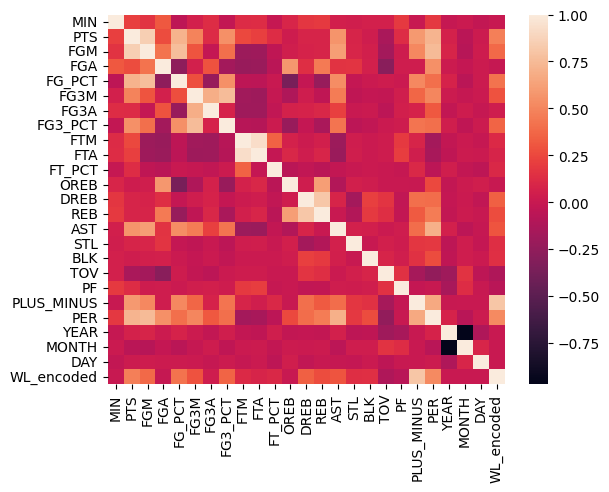

In [80]:
# Data Visualization to understand the variables better
# Heat Map

sns.heatmap(season_data.corr()) #coor for coordinates


In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Define the columns for the dependent (y) and independent (X) variables
#X_columns = ['PLUS_MINUS', 'PER','TEAM_NAME']  # Update the column names here
X_columns = ['PLUS_MINUS', 'TEAM_NAME']  # Update the column names here
y_column = 'WL_encoded'

# Update season_data with encoded features
labelencoder = LabelEncoder()
season_data['TEAM_NAME'] = labelencoder.fit_transform(season_data['TEAM_NAME'])
season_data['MATCHUP'] = labelencoder.fit_transform(season_data['MATCHUP'])
print(season_data.head())

categorical_columns = ['TEAM_NAME', 'MATCHUP','GAME_ID', 'YEAR', 'MONTH','DAY']
onehotencoder = OneHotEncoder()
X_encoded = onehotencoder.fit_transform(season_data[categorical_columns]).toarray()

X_encoded_df = pd.DataFrame(X_encoded, columns=onehotencoder.get_feature_names_out(categorical_columns))
season_data_encoded = pd.concat([season_data.drop(categorical_columns, axis=1), season_data['TEAM_NAME'], X_encoded_df], axis=1)

# Define X and y using the updated season_data_encoded
X = season_data_encoded[X_columns]
y = season_data_encoded[y_column]

# Drop rows with missing values
X.dropna(inplace=True)
y = y[X.index]

# Reset the index of X and y to align with each other
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Confirm the shape of X and y after handling missing values
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


    SEASON_ID TEAM_ABBREVIATION  TEAM_NAME     GAME_ID  GAME_DATE  MATCHUP WL  \
640     42022               MIA         14  0042200405 2023-06-12      819  L   
641     42022               DEN          6  0042200405 2023-06-12      391  W   
659     42022               DEN          6  0042200404 2023-06-09      362  W   
664     42022               MIA         14  0042200404 2023-06-09      848  L   
689     42022               DEN          6  0042200403 2023-06-07      362  W   

     MIN  PTS  FGM  ...  STL  BLK  TOV  PF  PLUS_MINUS  PER  YEAR  MONTH  DAY  \
640  240   89   33  ...    9    7    8  21        -5.0  112  2023      6   12   
641  240   94   38  ...    6    7   14  13         5.0  120  2023      6   12   
659  242  108   39  ...   11    7    6  18        13.0  125  2023      6    9   
664  240   95   35  ...    2    3   14  19       -13.0   94  2023      6    9   
689  238  109   41  ...    3    5   13  18        15.0  127  2023      6    7   

     WL_encoded  
640     

C:\Users\ghadf\AppData\Local\Temp\ipykernel_17372\4029996601.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


In [82]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Create a linear regression model and fit it to the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_lr = lr_model.predict(X_test)

# Get the team names from the original dataset for the test set
team_names_test = season_data_encoded.loc[X_test.index, 'TEAM_NAME'].reset_index(drop=True)

# Create a DataFrame with team names and predicted probabilities for linear regression
probabilities_df_lr = pd.DataFrame({'TEAM_NAME': team_names_test, 'Probability': y_pred_lr})

# Remove duplicates from df1 based on 'player_name' column
team_abbrev_unique = season_data.drop_duplicates(subset='TEAM_ABBREVIATION')

# Perform the SQL join
probabilities_df_lr = probabilities_df_lr.merge(team_abbrev_unique[['TEAM_NAME', 'TEAM_ABBREVIATION']], on='TEAM_NAME', how='left')

# Map probabilities to binary outcomes (W or L) based on a threshold of 0.5
probabilities_df_lr['Prediction'] = probabilities_df_lr['Probability'].apply(lambda x: 'W' if x >= 0.5 else 'L')

# Reset the index of probabilities_df_lr for proper display
probabilities_df_lr.reset_index(drop=True, inplace=True)

# Drop any rows with missing team names (if any)
probabilities_df_lr.dropna(subset=['TEAM_NAME'], inplace=True)

# Sort the DataFrame by probabilities in descending order for linear regression
probabilities_df_lr = probabilities_df_lr.sort_values('Probability', ascending=False)

# Print the table of teams with their probabilities for linear regression
print("Linear Regression Predictions:")
print(probabilities_df_lr)


Linear Regression Predictions:
     TEAM_NAME  Probability TEAM_ABBREVIATION Prediction
347        0.0     1.680744               ATL          W
396       20.0     1.278041               ORL          W
324       28.0     1.219758               WAS          W
262        6.0     1.191843               DEN          W
385       17.0     1.133672               NOP          W
..         ...          ...               ...        ...
479       21.0     0.011910               PHI          L
104        4.0    -0.045816               CHI          L
258       12.0    -0.074139               LAL          L
267       17.0    -0.189367               NOP          L
306       25.0    -0.333253               SAS          L

[74 rows x 4 columns]


In [83]:
#Predict Template
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Create a linear regression model and fit it to the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_lr = lr_model.predict(X_test)

# Evaluate the accuracy of the model using mean squared error and R-squared
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"LR Mean squared error: {mse_lr:.2f}")
print(f"LR R-squared: {r2_lr:.2f}")

LR Mean squared error: 0.09
LR R-squared: 0.62
